<h2>Question 1<\h2>
<h4>The reason<\h4>

In [1]:
%pylab

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
import cv2
from itertools import product
from tqdm import tqdm
from numba import jit

In [3]:
left = cv2.imread("A4_files/000020_left.jpg").astype(float)/255
right = cv2.imread("A4_files/000020_right.jpg").astype(float)/255
with open("A4_files/000020.txt") as file:
    x_min, y_min, x_max, y_max = [float(i) for i in file.read().split()[1:]]
with open("A4_files/000020_allcalib.txt") as file:
    f, px, py, baseline = [float(i) for i in file.read().split()[1::2]]
print(x_min, y_min, x_max, y_max, f, px, py, baseline)

685.05 181.43 804.68 258.21 721.5377 609.5593 172.854 0.5327119288


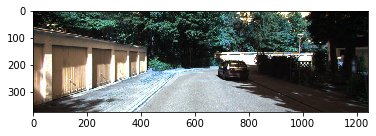

In [4]:
patchsize = 5
imshow(left)

True

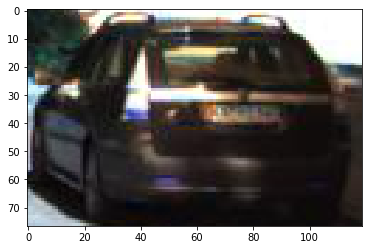

In [5]:
tar = left[int(y_min):int(y_max), int(x_min):int(x_max)]
imshow(tar)
cv2.imwrite("car.png", tar)

### Q2
a. I am using NC for this part

In [6]:
@jit(nopython=True, fastmath=True)
def SSD(patch1, patch2):
    return np.sum((patch1 - patch2)**2)

@jit(nopython=True, fastmath=True)
def NC(patch1, patch2):
    return np.sum(patch1*patch2)/np.sqrt(np.sum(patch1**2))/np.sqrt(np.sum(patch2**2))

@jit(nopython=True)
def rowler(patch, imgr, row_idx):
    patchsize = patch.shape[0]
    row = imgr[row_idx:row_idx+patchsize]
    ssd_list = []
    for i in range(row.shape[1]-patchsize+1):
        ssd_list.append(NC(patch, imgr[row_idx:row_idx+patchsize, i:i+patchsize]))
    return np.array(ssd_list).T

@jit(nopython=True)
def disparity(imgl, imgr, y_l, x_l, patch_size, y_min):
    patch = imgl[y_l:y_l+patch_size, x_l:x_l+patch_size]
    row_idx = y_l
    ssd_list = rowler(patch, imgr, row_idx)
    x_r = ssd_list.argmax()
    return x_l - x_r 

@jit(nopython=True, parallel=True)
def img_disp(imgl, imgr, patch_size, x_min, y_min, x_max, y_max):
    dy = y_max - y_min
    dx = x_max - x_min
    new_img = np.zeros((dy-patch_size+1, dx-patch_size+1))
    for y in range(y_min, y_max-patch_size+1):
        for x in range(x_min, x_max-patch_size+1):
            new_img[y - y_min, x - x_min] = disparity(imgl, imgr, y, x, patch_size, y_min)
    return new_img

In [7]:
imgl = left
imgr = right
patch_size = 5

# new_img = img_disp(imgl, imgr, patch_size, int(x_min), int(y_min), int(x_max), int(y_max))

In [8]:
# imshow(new_img, cmap="jet")
# colorbar()

In [9]:
# imshow(f*baseline/new_img, cmap="jet")
# colorbar()

b. The result of the training image is as following. 

In [10]:
deeppruner_result = cv2.imread("DeepPruner_result.png")

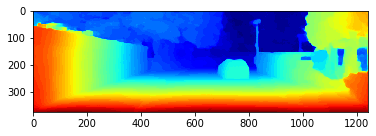

In [11]:
imshow(deeppruner_result[...,0], cmap="jet")

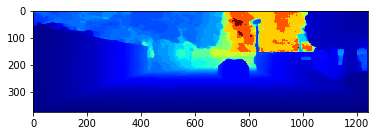

In [12]:
depth = f*baseline/deeppruner_result[...,0]
imshow(depth, cmap="jet")

c. This Network has the following procedures:

![Overview](overview.png)

- Feature Extractor

    The Feature Extractor create a pixel wide feature representation by downsampling networks. Creating a feature map that is 1/4 of the original input image size. 
    
- Differentiable Patch Match
    
    The differentiable patch matching is achieved by using a PatchMatch-based prunner that predict a confidence range for each pixel and construct a sparse cost volume. 
    The prunning module can be show as follows:
    1. Particle Sampling Layer:
       
       Generate disparity values for each pixel, from our search space. 
       
    2. Propagation Layer:
        
        Use convolution to propagate adjacent pixels.
    
    3. Evaluation Layer:
        
        Computer inner product of left and right feature and use it as matching score. 

- Confidence Range Prediction

    The Confidence Range Prediction is achieved by predicting the disparity range of each pixel. This prediction is achieved using an encoder-decoder structure.
    
- 3D Cost Aggregation 

    Use a 3D cost Volume estimator and do spactial aggregation. 
    
- Refinement
    
    Use a light weight fully convolutional network to refine the image (reduce noise and impove image quality). 
    

d. Based ont the depth information we have car pixel as following

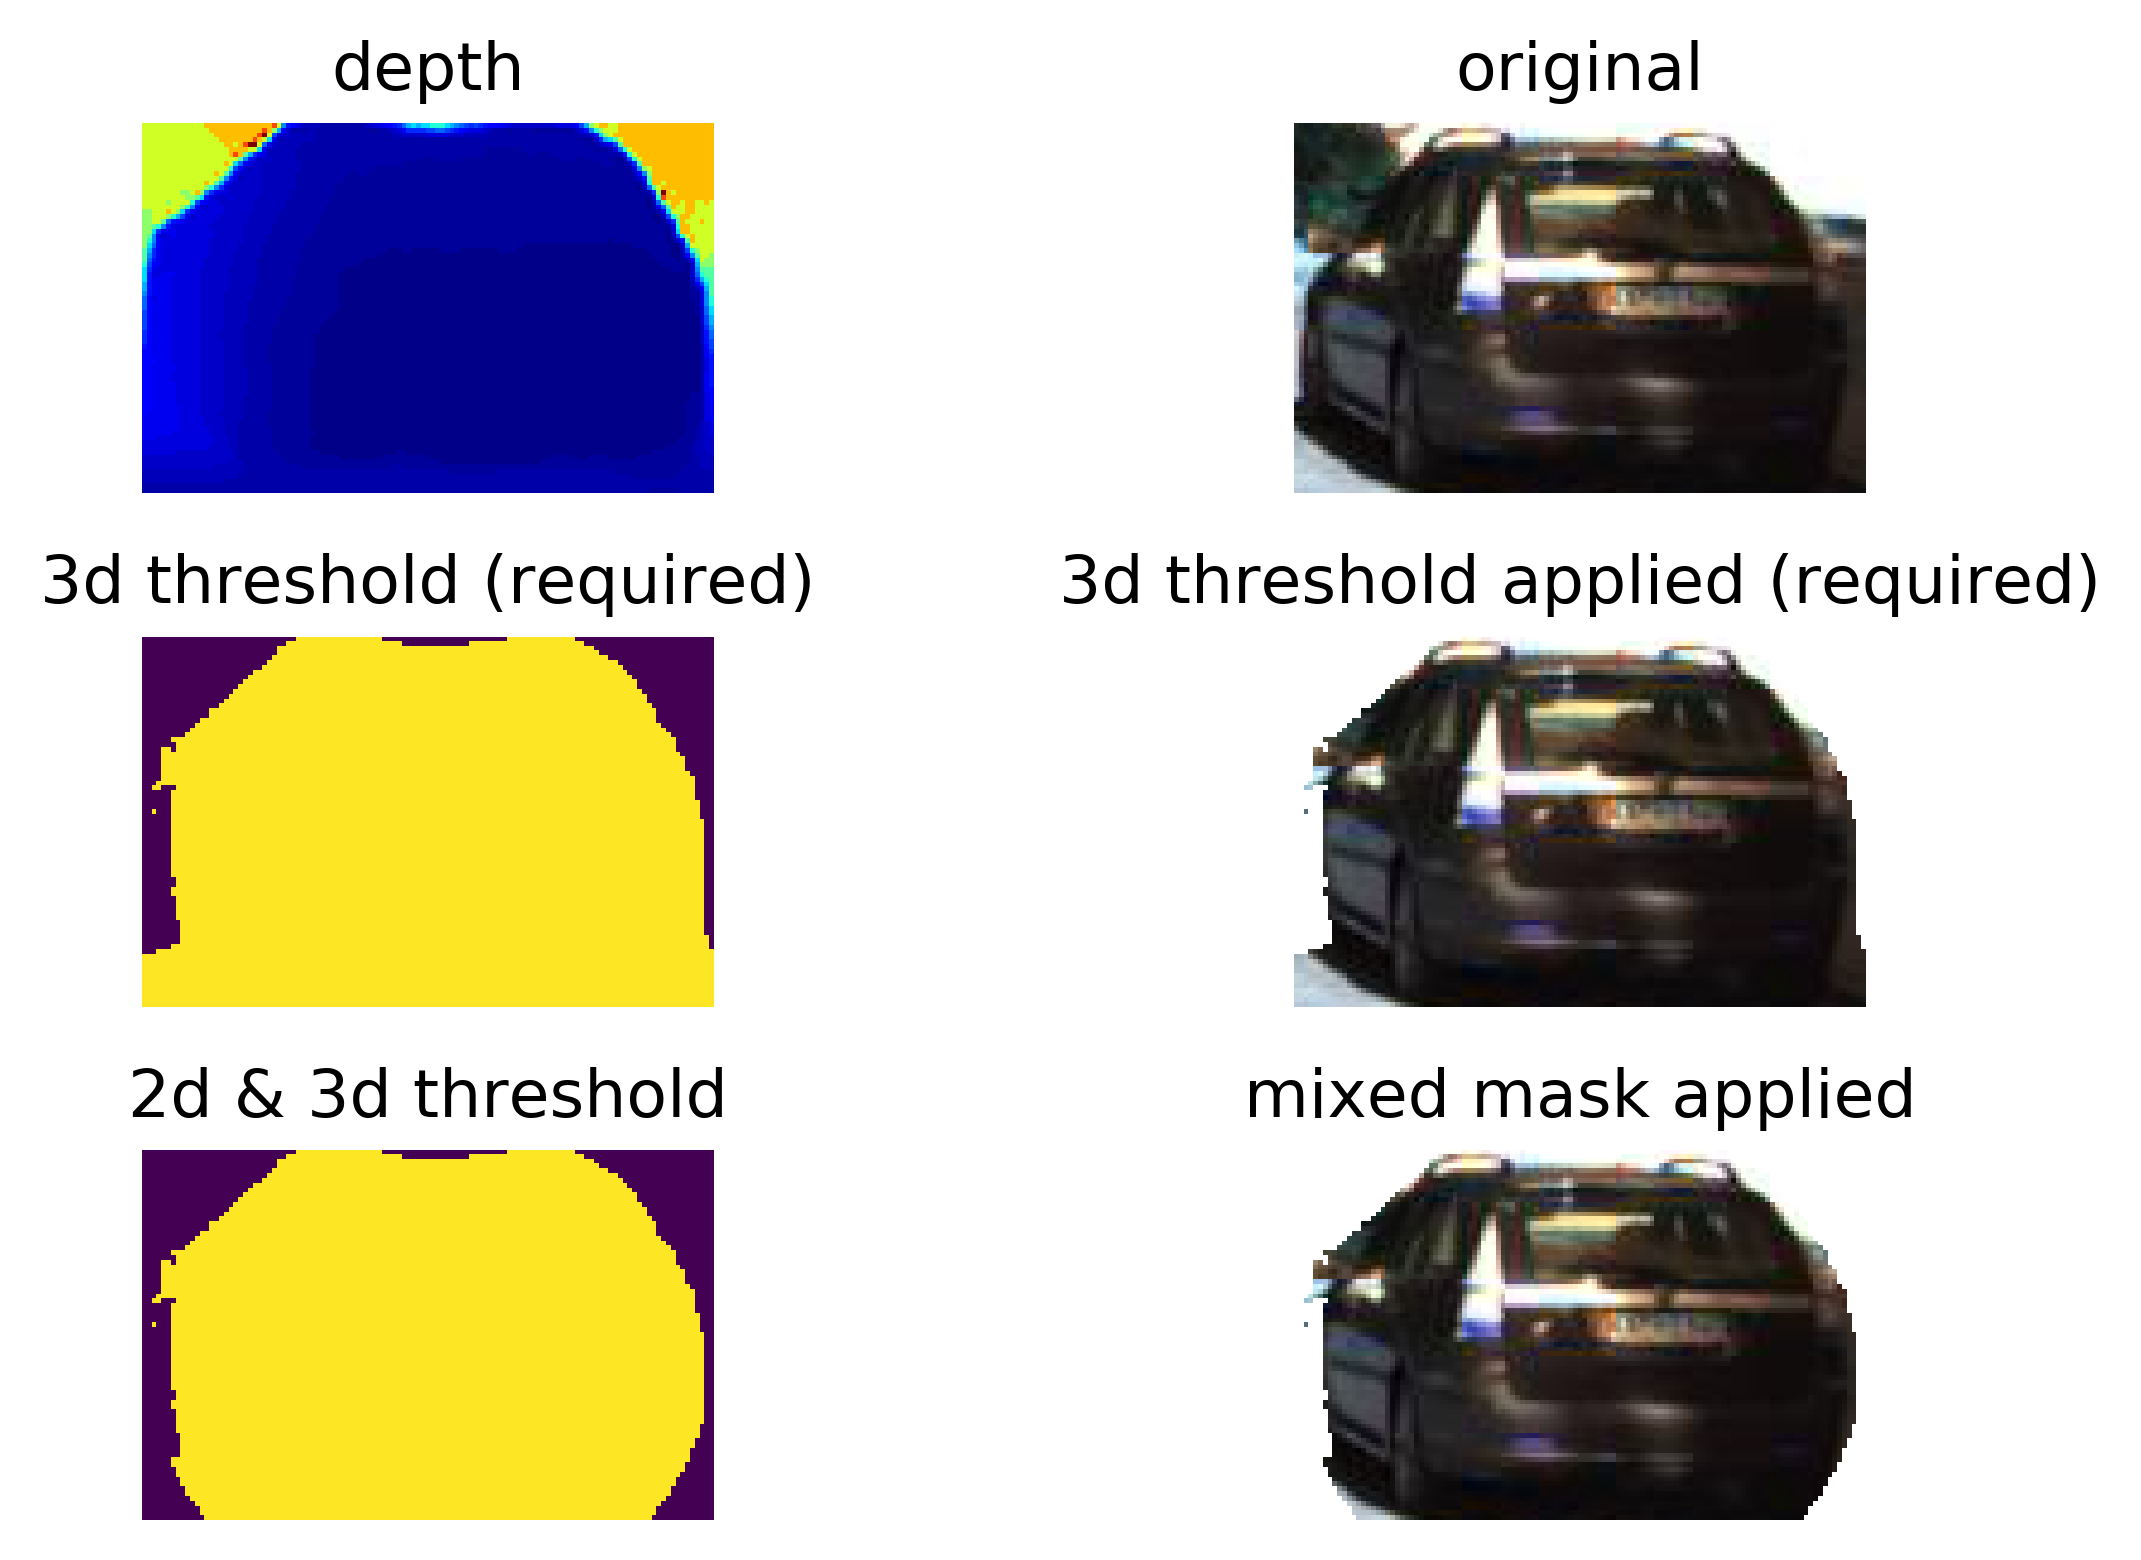

In [13]:
def transform2to3(x, y, z):
    X = z*(x-px)/f
    Y = z*(y-py)/f
    Z = z
    return X, Y, Z
    

bb = depth[int(y_min):int(y_max), int(x_min):int(x_max)]
x_center = int((x_max + x_min)/2)
y_center = int((y_max + y_min)/2)
z_center = depth[y_center, x_center]
center_2d = np.array([y_center, x_center, z_center])

X_center, Y_center, Z_center = transform2to3(x_center, y_center, z_center)
center_3d = np.array([Y_center, X_center, Z_center])

new_img = zeros_like(bb)
cord = np.array(np.where(new_img==0))
cord[0] = cord[0] + y_min
cord[1] = cord[1] + x_min
twod = np.vstack((cord, bb.flatten()))
threed = []
for key, row in enumerate(twod.T):
    y, x, z= row
    X, Y, Z = transform2to3(x, y, z)
    threed.append([Y, X, Z])
threed = np.array(threed)
dist_3d = np.sqrt(np.sum((threed - center_3d)**2, axis=1))
dist_2d = np.sqrt(np.sum((twod.T - center_2d)**2, axis=1))

figure(dpi=400)

subplot(321)
imshow(bb, cmap=cm.jet)
title("depth")
axis("off")

subplot(322)
imshow(tar)
axis("off")
title("original")

subplot(323)
selection_3d = dist_3d < 3.5
mask_3d = selection_3d.reshape(bb.shape)
imshow(mask_3d)
axis("off")
title("3d threshold (required)")

subplot(324)
car = ones_like(tar)
car[mask_3d] = tar[mask_3d]
imshow(car)
axis("off")
title("3d threshold applied (required)")

subplot(325)
selection_2d = dist_2d < 60
mask_2d = selection_2d.reshape(bb.shape)
mask_mix = mask_2d*mask_3d
imshow(mask_2d*mask_3d)
axis("off")
title("2d & 3d threshold")

subplot(326)
mask_mix = mask_2d*mask_3d
car = ones_like(tar)
car[mask_mix] = tar[mask_mix]
imshow(car)
axis("off")
tight_layout()
title("mixed mask applied")
print()

Note: While we are only reqired to compute 3d distance. We actually get a more refined image by combining 2d and 3d distance. 

In [25]:
car_3d = threed[mask_mix.flatten()]
strict_3d = threed[dist_3d < 1]
y_min, y_max = car_3d[..., 0].min(), car_3d[..., 0].max()
z_min_coord = car_3d[strict_3d[..., 2].argmin()][1:]
x_min_coord = car_3d[car_3d[..., 1].argmin()][1:]
x_max_coord = car_3d[car_3d[..., 1].argmax()][1:]
z_max_coord = x_min_coord+x_max_coord-z_min_coord

bounding_box = [[[y_min, *z_min_coord], {"y":-1, "x":0, "z":-1}],
[[y_min, *x_min_coord], {"y":-1, "x":-1, "z":0}],
[[y_min, *z_max_coord], {"y":-1, "x":0, "z":1}],
[[y_min, *x_max_coord], {"y":-1, "x":1, "z":0}],
[[y_max, *z_min_coord], {"y":1, "x":0, "z":-1}],
[[y_max, *x_min_coord], {"y":1, "x":-1, "z":0}],
[[y_max, *z_max_coord], {"y":1, "x":0, "z":1}],
[[y_max, *x_max_coord], {"y":1, "x":1, "z":0}]]


bounding_box_3d = [[np.array(i[0]), np.array(list((i[1].values())))] for i in bounding_box]

k = zeros([3,3])
k[0,0] = f
k[1,1] = f
k[1,2] = px
k[0,2] = py
k[2,2] = 1

bounding_box_2d = [[(np.matmul(k, i[0])[:2]/np.matmul(k, i[0])[2]).astype(int), i[1]] for i in bounding_box_3d]

(181, 730) (181, 730)
(181, 730) (180, 689)
(181, 730) (180, 794)
(181, 730) (258, 730)
(180, 689) (181, 730)
(180, 689) (180, 689)
(180, 689) (179, 753)
(180, 689) (252, 689)
(179, 753) (180, 689)
(179, 753) (179, 753)
(179, 753) (180, 794)
(179, 753) (243, 753)
(180, 794) (181, 730)
(180, 794) (179, 753)
(180, 794) (180, 794)
(180, 794) (248, 794)
(258, 730) (181, 730)
(258, 730) (258, 730)
(258, 730) (252, 689)
(258, 730) (248, 794)
(252, 689) (180, 689)
(252, 689) (258, 730)
(252, 689) (252, 689)
(252, 689) (243, 753)
(243, 753) (179, 753)
(243, 753) (252, 689)
(243, 753) (243, 753)
(243, 753) (248, 794)
(248, 794) (180, 794)
(248, 794) (258, 730)
(248, 794) (243, 753)
(248, 794) (248, 794)


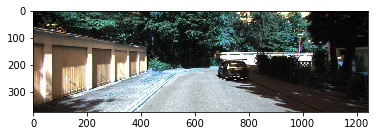

In [26]:
def poly_get_adj(pt, all_pt):
    adj = []
    for i in all_pt:
        if not -1 in (i[1] *pt[1])[1:]:
            if (i[1] *pt[1])[0] != -1 or 1 in (i[1] *pt[1]):
                adj.append(i)
    return adj

def enforce(img, rr, cc, width):
    for y, x in np.array([rr, cc]):
        img



from skimage.draw import line_aa, set_color
img = (left.copy()*255).astype(np.uint8)
for p in bounding_box_2d:
    for adj in poly_get_adj(p, bounding_box_2d):
        pt1 = (int(p[0][0]), int(p[0][1]))
        pt2 = (int(adj[0][0]), int(adj[0][1]))
        print((int(p[0][0]), int(p[0][1])), (int(adj[0][0]), int(adj[0][1])))
        rr, cc, val = line_aa(*pt1, *pt2)
        img[rr, cc] = (val*255)[...,np.newaxis]
imshow(img)
savefig("boxed.png", dpi=400)
# imshow(img)

### Q3

In [17]:
I1 = cv2.imread("./I1.jpg")
I2 = cv2.imread("./I2.jpg")
I3 = cv2.imread("./I3.jpg")

In [18]:
sift = cv2.xfeatures2d.SIFT_create()

(-0.5, 12095.5, 3023.5, -0.5)

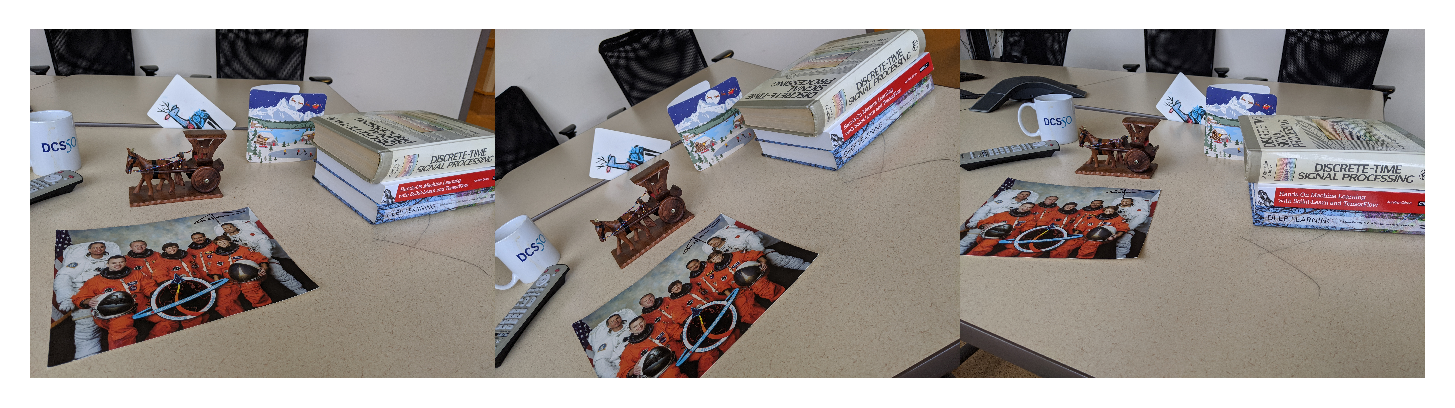

In [19]:
fig = figure(dpi=300)
imshow(np.hstack([I1,I2,I3])[..., ::-1])
axis("off")

In [20]:
def apply_thres(matched_points):
    results = []
    for thres in np.linspace(1, 0, 500):
        results.append((thres, np.sum(matched_points[...,2]<thres)))
    return np.array(results)

 
def sort_mp(mp):
    sort_idx = mp[...,2].argsort()
    return mp[sort_idx]

 
def get_unique(mp):
    sort = sort_mp(mp)
    match = np.concatenate((cv2.KeyPoint_convert(sort[...,0]), cv2.KeyPoint_convert(sort[...,1])), axis=1)
    match = pd.DataFrame(match).reset_index()
    max01 = set(match.groupby([0,1]).max()["index"])
    max23 = set(match.groupby([2,3]).max()["index"])
    unique = match.loc[(max01 & max23)]
    return unique.values[:, 1:]

     
def drawKeypoints(img, kp, color=(255, 0, 0), radius=False):
    img = img.copy()
    if img.ndim == 2:
        img = np.dstack((img, img, img))
    if not radius:
        radius = min(img.shape)// 50
    for p in kp:
        img = cv2.circle(img, (int(p.pt[0]), int(p.pt[1])), radius, color, thickness=-1)
    return img

 
def normalize_des(des):
    norm_des = des / np.sum(des, axis=1)[...,np.newaxis]
    norm_des = np.clip(norm_des, 0, 0.2)
    norm_des = norm_des / np.sum(norm_des, axis=1)[...,np.newaxis]
    return norm_des

 
def match(des1, des2, kp1, kp2, L=2):
    norm1 = normalize_des(des1)
    norm2 = normalize_des(des2)
    matched_points = []
    for v in range(norm1.shape[0]):
        dist = np.sum(np.abs(norm1[v] - norm2)**L, axis=1)**(1/L)
        min_idx = dist.argmin()
        min_value = dist[min_idx]
        dist[min_idx] = float("inf")
        min2_idx = dist.argmin()
        ratio = min_value/dist[min2_idx]
        matched_points.append((kp1[v], kp2[min_idx], ratio))
    return np.array(matched_points)

 
def draw_matching_lines(img1, img2, match, color=(255,0,0), size=5):
    h = img1.shape[1]
    img = np.hstack((img1, img2))
    for i in range(match.shape[0]):
        pt1 = np.array(match[i, 1].pt).astype(int)
        pt2 = np.array(match[i, 2].pt).astype(int)
        pt2[0] += h
        img = cv2.line(img, tuple(pt1), tuple(pt2), color, size)
    return img


def get_sparse(mp, num=8, min_dist=50, best=True):
    if best:
        mp = sort_mp(mp)
    pairs = []
    for p in mp:
        if len(pairs) == 8:
            return np.array(pairs)
        if not pairs:
            pairs.append(p)
        else:
            for pair in pairs:
                if np.sqrt(np.sum((np.array(pair[0].pt)-np.array(p[0].pt))**2)) < min_dist:
                    break
                if np.sqrt(np.sum((np.array(pair[1].pt)-np.array(p[1].pt))**2)) < min_dist:
                    break
                else:
                    pairs.append(p)
    print("No solution")

def get_match(img1, img2):
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)
    mp = match(des1, des2, kp1, kp2, L=2)
    return mp

def draw_match(img1, img2, mp, file):
    pt1, pt2 = drawKeypoints(img1, mp[...,0], radius=50), drawKeypoints(img2, mp[...,1], radius=50)
    line = draw_matching_lines(pt1, pt2, mp)
    fig = figure(dpi=400)
    imshow(line)
    savefig(file)

mp1 = get_match(I1, I2)
mp2 = get_match(I1, I3)

sparse1 = get_sparse(mp1)
sparse2 = get_sparse(mp2)

draw_match(I1, I2, mp1, "match1-2.png")
draw_match(I1, I3, mp2, "match1-3.png")
draw_match(I1, I2, mp1, "sparse1-2.png")
draw_match(I1, I3, mp2, "sparse1-3.png")